# Import Required Libraries
---

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline
import plotly.graph_objects as go
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report
from scipy import interp
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import tree
from sklearn import preprocessing
from sklearn.inspection import permutation_importance


# Data Cleaning
---
Following columns are ignored

* Sl. No., Reference are just description columns
* Location is redundant as latitude and longitude are already given
* ORIGIN TIME - UTC and IST have very less number values. Hence they are ignored as they don't add much value either
* Mb, Ms, ML are derivatives of Mw. Hence ignored
* Intensity, MMI, MME are also dropped as they have very less number of values

Column Mw is the parameter that we have to classify and Lat, Lon are important parameters that should not be guessed. Hence removing rows with null Mw, Lat, Lon values.

* Year, Date are filled with stratergy 'ffill'.
* Depth is filled with mean of data grouped by Mw. Few still remaining values are filled with mean.
* Mw column has about 50k values, while MAGNITUDE has only 40k. So used Mw is used renamed the column as MAGNITUDE



In [2]:
# Followed above explanation and converted all to appropriate data types
data_path = 'https://raw.githubusercontent.com/nee2shaji/DataAnalytics/master/IndianEarthquakes.csv'
eq_data = pd.read_csv(data_path, encoding = 'unicode_escape', skiprows=10, names=['Sl.No.','YEAR' ,'MONTH' ,'DATE','ORIGIN TIME(UTC)','ORIGIN TIME(IST)','MAGNITUDE','Mw','Mb1','Mb2','Ms','ML','LAT','LONG','DEPTH','INTENSITY','MMI','MME','LOCATION','REFERENCE'])

eq_data = eq_data[['YEAR' ,'MONTH' ,'DATE', 'Mw','LAT','LONG','DEPTH']]
eq_data.columns = ['YEAR' ,'MONTH' ,'DATE', 'MAGNITUDE','LAT','LONG','DEPTH']
print(eq_data.count(axis=0))

# Magnitude Lat Long to float
eq_data['MAGNITUDE'] = eq_data['MAGNITUDE'].astype(str).str.extract('([0-9]+\.?[0-9]*)').astype(float)
eq_data = eq_data[~eq_data['MAGNITUDE'].isna()]

# Converting Lat Long to float
eq_data['LAT'] = eq_data['LAT'].astype(str).str.extract('([0-9]+\.?[0-9]*)').astype(float)
eq_data['LONG'] = eq_data['LONG'].astype(str).str.extract('([0-9]+\.?[0-9]*)').astype(float)
eq_data = eq_data[~eq_data['LAT'].isna()]

#Year, Date are filled with stratergy 'ffill'.
eq_data['YEAR'] = pd.to_numeric(eq_data['YEAR'], errors="coerce").fillna(method='ffill').astype(int)
eq_data = eq_data[eq_data['YEAR']>1800]
eq_data['MONTH'] = pd.to_numeric(eq_data['MONTH'], errors="coerce").fillna(method='ffill').astype(int)
eq_data['DATE'] = pd.to_numeric(eq_data['DATE'], errors="coerce").fillna(method='ffill').astype(int)

#Depth is filled with mean of data grouped by Mw
eq_data['DEPTH'] = eq_data['DEPTH'].astype(str).str.extract('([0-9]+\.?[0-9]*)').astype(float)
eq_data['DEPTH'].fillna(eq_data.groupby(['MAGNITUDE'])['DEPTH'].transform('mean'), inplace=True)
eq_data['DEPTH'].fillna(eq_data['DEPTH'].mean(), inplace=True)

print("\n\nChecking if there are any more NaN values")
print(eq_data.isna().sum())
print("\n\nPrinting count of all columns")
print(eq_data.count(axis=0))

final_data = eq_data[['YEAR' ,'MONTH' ,'DATE', 'MAGNITUDE','LAT','LONG','DEPTH']]



/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2,6,7,9,10,11,12,13,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.



YEAR         52989
MONTH        52971
DATE         52932
MAGNITUDE    50486
LAT          52989
LONG         52989
DEPTH        50811
dtype: int64


Checking if there are any more NaN values
YEAR         0
MONTH        0
DATE         0
MAGNITUDE    0
LAT          0
LONG         0
DEPTH        0
dtype: int64


Printing count of all columns
YEAR         50424
MONTH        50424
DATE         50424
MAGNITUDE    50424
LAT          50424
LONG         50424
DEPTH        50424
dtype: int64


# Selecting Threshold
---

* This step we try to find out the threshold. The value of the threshold whether or not to call it an earthquake is given by the value of Mw that they have asked us to choose from [4,5].
* Since better classification can be done when the classes are more balanced. We suggest we choose the cut off in such a way that the number of samples in each class are almost the same.
* In the next code block we are trying to do the above step and also provide the histogram to see the distribution of counts.


ThresholdSetting Class1Count Class2Count
4.00 45980 4444
4.25 35855 14569
4.50 25757 24667
4.75 16229 34195
5.00 9503 40921


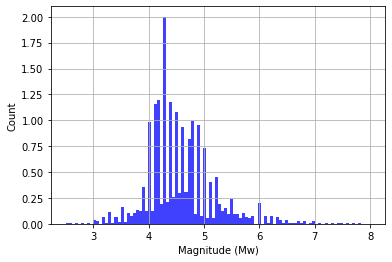

In [3]:
print("ThresholdSetting", "Class1Count", "Class2Count")
for T in np.linspace(4,5,5):
  print("{:.2f}".format(T), eq_data[eq_data['MAGNITUDE']>=T]['MAGNITUDE'].count(),eq_data[eq_data['MAGNITUDE']<T]['MAGNITUDE'].count())
  
plt.figure()
plt.hist(eq_data['MAGNITUDE'], 100, range=(2.5, 8), density=True, facecolor='b', alpha=0.75)
plt.xlabel('Magnitude (Mw)')
plt.ylabel('Count')
plt.grid(True)

# Setting threshold as 4.5 as it has the most balanced dataset
T = 4.5


# Train Test Splits
---
We have decided the threshold to be 4.5. The next step is to define y (the output) based on values of Mw and the Train Test Splits, we have chosen ```[Train, Test] Ratio = [0.8, 0.2]``` and used ```StandardScaler()``` as a preprocessing step before feeding into the KNN classifier. For Decision Tree direct input is taken in its raw form without any preprocessing.

In [4]:
X = eq_data[['YEAR' ,'MONTH' ,'DATE','LAT','LONG','DEPTH']]
y = eq_data['MAGNITUDE'] >= T

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train.shape, X_test.shape, y_train.shape, X_test.shape)

plt.style.use('seaborn')

(40339, 6) (10085, 6) (40339,) (10085, 6)


# Part 1 : ROC Curve for KNN 
---
We have used K  (number of neighbours) as parameter in KNN and tuned this value of K to get  a number of classifiers with their respective ROC Curves, as shown below.

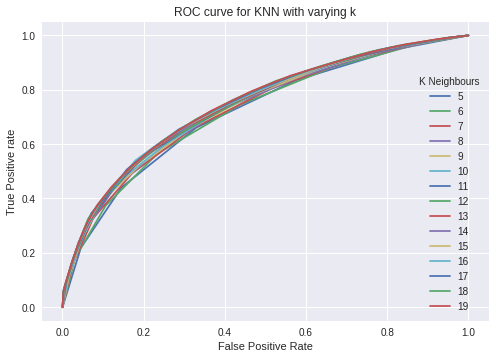

,Neighbors,Training Set Score,Test Set Score,AUC Score
0,5,0.771363,0.665444,0.716523
1,6,0.751927,0.662568,0.719351
2,7,0.74873,0.668121,0.726491
3,8,0.738219,0.668418,0.73076
4,9,0.739632,0.671096,0.733038
5,10,0.729964,0.670302,0.735851
6,11,0.731079,0.673178,0.737953
7,12,0.725972,0.675459,0.739372
8,13,0.726443,0.677739,0.741016
9,14,0.721262,0.677938,0.74286


In [5]:
# KNN Classifier

neighbors = np.arange(5, 20)
#neighbours = np.linspace(5,51,num = 15)
knn_scores = pd.DataFrame(columns=["Neighbors", "Training Set Score", "Test Set Score", "AUC Score"])
tr_scr = []
tes_scr = []
auc_scr=[]

#fig = go.Figure()
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    # ROC curve
    knn_pred_prob = knn.predict_proba(X_test_scaled)
    knn_fpr, knn_tpr, knn_thresh = roc_curve(y_test, knn_pred_prob[:,1])
    knn_scores.loc[i, "Neighbors"] = k
    auc_scr.append(roc_auc_score(y_test, knn_pred_prob[:,1]))
    knn_scores.loc[i, "AUC Score"] = roc_auc_score(y_test, knn_pred_prob[:,1])
    tr_scr.append(knn.score(X_train_scaled, y_train))
    knn_scores.loc[i, "Training Set Score"] = knn.score(X_train_scaled, y_train)
    tes_scr.append(knn.score(X_test_scaled, y_test))
    knn_scores.loc[i, "Test Set Score"] = knn.score(X_test_scaled, y_test)

    # Plot ROC Curve
    plt.plot(knn_fpr, knn_tpr, linestyle='-', label=k)
    #fig.add_trace(go.Scatter(x=knn_fpr, y=knn_tpr, name=str(k)))

plt.title('ROC curve for KNN with varying k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best', title="K Neighbours")
plt.show() 

#fig.show()
knn_scores
# The curve will look better when we reduce the number of neighbors plotted. Right now plotted many to know the training and test scores


In [6]:

fig = go.Figure(data=go.Scatter(x=neighbors, y=auc_scr,name = 'AUC'))
fig.add_trace(go.Scatter(x=neighbors, y=tr_scr,name = 'Train Score'))
fig.add_trace(go.Scatter(x=neighbors, y=tes_scr,name = 'Test Score'))
fig.show()


# Part 1 : ROC Curve for Decision Tree
---
We have used Pre-prune depth as parameter in Decision Tree and tuned this value of depth to get  a number of classifiers with their respective ROC Curves, as shown below. Procedure is similar to KNN classifier, the best classifer has the maximum AUC. 



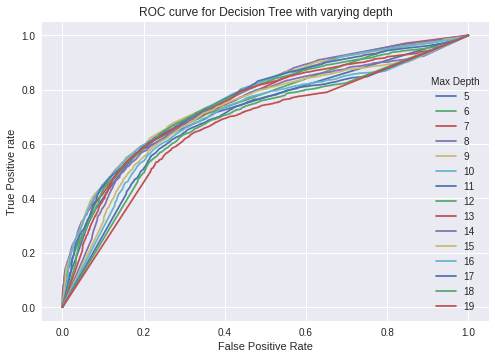

,Depth,Training Set Score,Test Set Score,AUC Score
0,5,0.68202,0.686267,0.723981
1,6,0.688317,0.69172,0.742922
2,7,0.694142,0.694001,0.758562
3,8,0.702348,0.697075,0.765802
4,9,0.714247,0.69995,0.766523
5,10,0.725377,0.696678,0.764426
6,11,0.741317,0.690431,0.757274
7,12,0.758645,0.696777,0.749195
8,13,0.777858,0.689638,0.739486
9,14,0.798185,0.685573,0.725392


In [7]:
# Decision Tree Classifier

depths = np.arange(5, 20)
dt_scores = pd.DataFrame(columns=["Depth", "Training Set Score", "Test Set Score", "AUC Score"])

for i, d in enumerate(depths):
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train, y_train)
    # ROC curve
    clf_pred_prob = clf.predict_proba(X_test)
    clf_fpr, clf_tpr, clf_thresh = roc_curve(y_test, clf_pred_prob[:,1])
    dt_scores.loc[i, "Depth"] = d
    dt_scores.loc[i, "AUC Score"] = roc_auc_score(y_test, clf_pred_prob[:,1])
    dt_scores.loc[i, "Training Set Score"] = clf.score(X_train, y_train)
    dt_scores.loc[i, "Test Set Score"] = clf.score(X_test, y_test)

    # Plot ROC Curve
    plt.plot(clf_fpr, clf_tpr, linestyle='-', label=d)

plt.title('ROC curve for Decision Tree with varying depth')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best', title="Max Depth")
plt.show() 

dt_scores


As shown in the table above the AUC curve value peaks at Desicion Tree with a depth of 9 and falls steadly after that. So therefore the best parameter for Decision tree is ```max_depth = 9``` .

# Part 2 - Better Classifier Among the two ?

Decision Tree seems to be the better classifier based on the AUC and also the Train, Test Accuracy Scores. Another observation from the observations below is that there is a trade off between the Training Set Score and the AUC. The best AUC doesn't guarantee a Training Set Score but improves the performance of the Test Set Score in both the classifiers.

The main deciding factors on which classifier is better is the Test Set Score and the AUC which is better in case of Decision Tree than KNN classifier.

```
KNN
Neighbours	Training Set Score	Test Set Score	AUC Score
5	          0.771363	          0.665444	       0.716523
18	         0.7168	            0.680714	       0.74725 (best)

Decision Tree
Depth	Training Set Score	Test Set Score	AUC Score
9	     0.714247	           0.700347	      0.76697 (best)
19	    0.902006	           0.657908	      0.667574
```



# Part 3 -  Best possible values of the parameters
---
The values of the parameters of the  classifiers are decided based on the ROC. 
The ROC curve shows the trade-off between ```True Positive Rate``` and ```(1 – False Positive Rate)```. Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a random classifier is expected to give points lying along the diagonal (FPR = TPR). The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.The curve which attains the maximum area under the curve (AUC) is said to be the better model. 

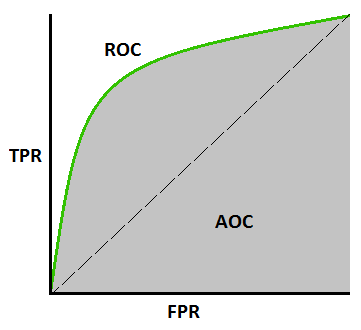



## So in our case, KNN shows the maximum AUC with ```k=18``` and Desicion Tree shows the best AUC with ```depth = 9```.

# Part 4 - Subset of two features
---
In this section we are trying to find the two most important features that we can use to determine the same classification problem. There are many ways to do this. We follow two different methods for KNN and Decision Tree.

In KNN, we use ```permutation_importance``` to find the important features based on the decrease in a model score when a single feature value is randomly shuffled. Out of these attributes we choose the top two features with the most model score.

In the Decision Tree, we have used the inbuilt function ```feature_importances_``` to find the most important features as shown in the graph below.

Feature: 0, Score: 0.11907
Feature: 1, Score: 0.02469
Feature: 2, Score: 0.01729
Feature: 3, Score: 0.08954
Feature: 4, Score: 0.04226
Feature: 5, Score: 0.03235


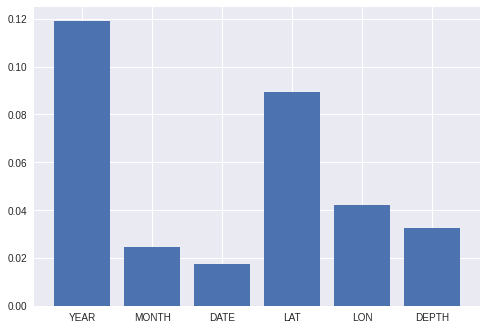

In [8]:
knn = KNeighborsClassifier(n_neighbors=18)
knn.fit(X_train_scaled, y_train)
results = permutation_importance(knn, X_test_scaled, y_test, scoring='accuracy')
importance = results.importances_mean
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar(['YEAR', 'MONTH', 'DATE', 'LAT', 'LON', 'DEPTH'], importance)
plt.show()

To select the most two important features for KNN Nearest Neighbour, we look at the model scores of the columns when shuffled. As observed above the features with the top scores are **YEAR** followed by **LATITUDE**.

The code below uses just these two features as inputs to the KNN classifer to determine the same output as we did before.

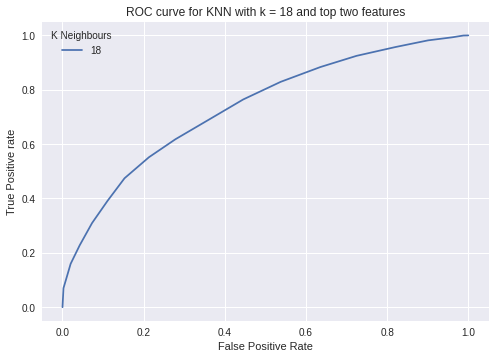

,Neighbors,Training Set Score,Test Set Score,AUC Score
0,18,0.706909,0.66822,0.734963


In [9]:
# KNN Classifier with 2 most important features 


scaler = StandardScaler()
X_trunc = X_train[['YEAR' ,'LAT']]
scaler.fit(X_trunc)
X_train_trunc = scaler.transform(X_trunc)
X_trunc = X_test[['YEAR' ,'LAT']]
X_test_trunc = scaler.transform(X_trunc)
#neighbors = np.arange(5, 50)
knn_scores = pd.DataFrame(columns=["Neighbors", "Training Set Score", "Test Set Score", "AUC Score"])
k = 18
i = 0
#for i, k in enumerate(neighbors):
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_trunc, y_train)
# ROC curve
knn_pred_prob = knn.predict_proba(X_test_trunc)
knn_fpr, knn_tpr, knn_thresh = roc_curve(y_test, knn_pred_prob[:,1])
knn_scores.loc[i, "Neighbors"] = k
knn_scores.loc[i, "AUC Score"] = roc_auc_score(y_test, knn_pred_prob[:,1])
knn_scores.loc[i, "Training Set Score"] = knn.score(X_train_trunc, y_train)
knn_scores.loc[i, "Test Set Score"] = knn.score(X_test_trunc, y_test)

# Plot ROC Curve
plt.plot(knn_fpr, knn_tpr, linestyle='-', label=k)

plt.title('ROC curve for KNN with k = 18 and top two features')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best', title="K Neighbours")
plt.show() 

knn_scores

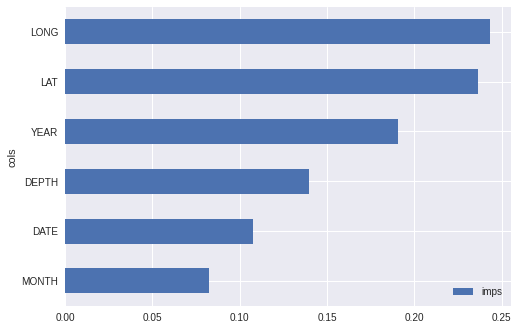

In [10]:
# Feature Importance of Decision Tree

col_sorted_by_importance=clf.feature_importances_.argsort()

dt_feat_imp = pd.DataFrame({
    'cols' : X.columns[col_sorted_by_importance],
    'imps' : clf.feature_importances_[col_sorted_by_importance]
})

dt_feat_imp.plot(kind = "barh", x='cols', y='imps')

The top two features are **Latitude** followed by **Longitude** when Threshold is 4.5 as descirbed in the above plot. The below plot gives us feature pairwise plot of decision tree of additional insights between the top two features.

This cell is followed by the code for a Decision Tree classifer with only use of the top two features deduced by the ```feature_importances_``` method.

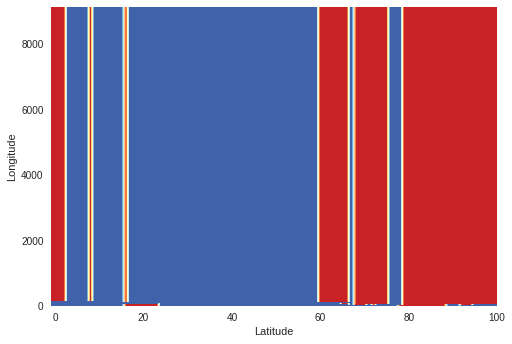

In [11]:
clf = DecisionTreeClassifier(max_depth=7)
X_plot = X_train[['LAT', 'LONG']]
clf.fit(X_plot, y_train)
#tree.plot_tree(clf);
x_min, x_max = X_plot.loc[:, 'LAT'].min() - 1, X_plot.loc[:, 'LAT'].max() + 1
y_min, y_max = X_train.loc[:, 'LONG'].min() - 1, X_plot.loc[:, 'LONG'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1))
plt.figure()
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()
# Reference : https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py
# This is a feature pairwise plot of decision tree. I just chose two most important pair of features (Latitude and Year) and plotted them.


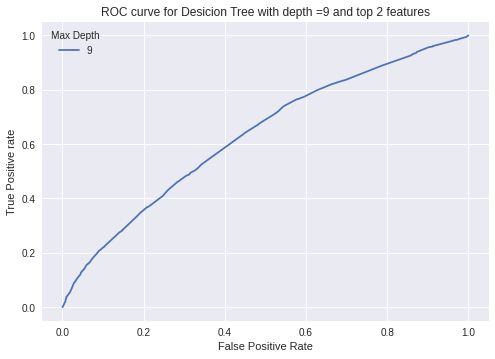

,Depth,Training Set Score,Test Set Score,AUC Score
0,9,0.628771,0.596827,0.632043


In [12]:
# Decision Tree Classifier with depth = 9 and top two features 
 
X_train_trunc = X_train[['LONG' ,'LAT']]
X_test_trunc = X_test[['LONG' ,'LAT']]

#depths = np.arange(5, 20)
dt_scores = pd.DataFrame(columns=["Depth", "Training Set Score", "Test Set Score", "AUC Score"])

#for i, d in enumerate(depths):
d = 9 
clf = DecisionTreeClassifier(max_depth=d)
clf.fit(X_train_trunc, y_train)
# ROC curve
clf_pred_prob = clf.predict_proba(X_test_trunc)
clf_fpr, clf_tpr, clf_thresh = roc_curve(y_test, clf_pred_prob[:,1])
dt_scores.loc[i, "Depth"] = d
dt_scores.loc[i, "AUC Score"] = roc_auc_score(y_test, clf_pred_prob[:,1])
dt_scores.loc[i, "Training Set Score"] = clf.score(X_train_trunc, y_train)
dt_scores.loc[i, "Test Set Score"] = clf.score(X_test_trunc, y_test)

# Plot ROC Curve
plt.plot(clf_fpr, clf_tpr, linestyle='-', label=d)

plt.title('ROC curve for Desicion Tree with depth =9 and top 2 features')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best', title="Max Depth")
plt.show() 

dt_scores

# Part 5 : Feature Processing
---
We have used inbuilt ```PolynomialFeatures``` for additional feature processing.  In this we generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to a given degree mentioned by us. We have taken the default value of degree as 2 itself and we have mentioned ```interaction_only = True``` to take only the features that are products of at most degree distinct input features.

We have used the Desicion Tree with the best configuration after the feature processing of parameters and compared it with the existing Decision Tree (without feature processing).



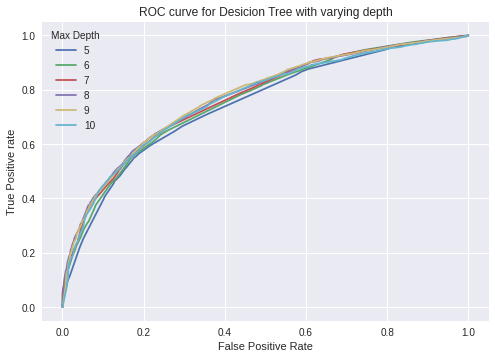

,Depth,Training Set Score,Test Set Score,AUC Score
0,5,0.681846,0.686564,0.744789
1,6,0.693597,0.694398,0.758456
2,7,0.704356,0.698166,0.765859
3,8,0.713974,0.701735,0.771773
4,9,0.72451,0.703223,0.772496
5,10,0.738144,0.698761,0.763817


In [13]:
# Q5 Additional features
poly = PolynomialFeatures(interaction_only=True)
#poly = PolynomialFeatures(6)
depths = np.arange(5, 11)
dt_scores = pd.DataFrame(columns=["Depth", "Training Set Score", "Test Set Score", "AUC Score"])

for i, d in enumerate(depths):
    clf = DecisionTreeClassifier(max_depth=d)
    X_train_poly = poly.fit_transform(X_train)
    clf.fit(X_train_poly, y_train)
    X_test_poly = poly.fit_transform (X_test)
    # ROC curve
    clf_pred_prob = clf.predict_proba(X_test_poly)
    clf_fpr, clf_tpr, clf_thresh = roc_curve(y_test, clf_pred_prob[:,1])
    dt_scores.loc[i, "Depth"] = d
    dt_scores.loc[i, "AUC Score"] = roc_auc_score(y_test, clf_pred_prob[:,1])
    dt_scores.loc[i, "Training Set Score"] = clf.score(X_train_poly, y_train)
    dt_scores.loc[i, "Test Set Score"] = clf.score(X_test_poly, y_test)

    # Plot ROC Curve
    plt.plot(clf_fpr, clf_tpr, linestyle='-', label=d)

plt.title('ROC curve for Desicion Tree with varying depth')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best', title="Max Depth")
plt.show() 

dt_scores


Taking the max AUC, the depth of the tree is determined to be 8. This is the best configuration of the Decision Tree after feature processing.


The accuracy both train and test has been improved by a small bit when compared to the previous methods without feature processing, as mentioned below.


```
Shape of Input : (40339, 6)
Before feature processing
	Depth	Training Set Score	Test Set Score	AUC Score
0	5	    0.848286	          0.85642	       0.765079
1	6	    0.849748	          0.85642	       0.774639
2	7	    0.853814	          0.856718	      0.780776
3	8	    0.857929	          0.85642	       0.781087
4	9	    0.861524	          0.858304	      0.782403
5	10	   0.86668	           0.853743	      0.783854

Shape of Input : (40339, 22)
After feature processing
	Depth	Training Set Score	Test Set Score	AUC Score
0	5	    0.848335	          0.856222	      0.763528
1	6	    0.850343	          0.854636	      0.771735
2	7	    0.856838	          0.859296	      0.776799
3	8	    0.859243	          0.858899	      0.777935
4	9	    0.863383	          0.854933	      0.780008
5	10	   0.869779	          0.854636	      0.779554
```



# Additional Analysis based on Threshold
---
In this code block we have looked at the range of thresholds and how it affects the performance. For reference the class balance is also shown in the code also. One intriguing observation is that when the class is not properly balanced or skewed the performance is better than the balanced class case. One case using KNN is shown where the threshold is 4.0 in first case and 4.5 in second. The rest of the thresholds and their results can be observed in the code block below.
```
------------------------------------------------------------------------------
Threshold=4.0, [Class1, Class2] Counts = [45980, 4444]
  Neighbors Training Set Score Test Set Score Precision    Recall  F1_score
0         5           0.931158        0.91056  0.931683  0.973384  0.952077
1         6            0.92744       0.906991  0.936899  0.962955  0.949748
2         7           0.927093       0.913634  0.929676  0.979468  0.953923
3         8           0.924986       0.911056  0.933793  0.971429  0.952239
4         9           0.924267       0.914725  0.929756  0.980663  0.954531
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Threshold=4.5, [Class1, Class2] Counts = [25757, 24667]
  Neighbors Training Set Score Test Set Score Precision    Recall  F1_score
0         5           0.771363       0.665444  0.680944  0.660512  0.670572
1         6           0.751927       0.662568  0.719882  0.565493  0.633416
2         7            0.74873       0.668121  0.685348  0.658588  0.671702
3         8           0.738219       0.668418  0.719631  0.584535  0.645086
4         9           0.739632       0.671096  0.689718  0.658011  0.673491
------------------------------------------------------------------------------
```
Regardless we have taken the balanced class case itself for all our experiments.

In [14]:

cnt = [[45980, 4444],[35855, 14569],[25757, 24667],[16229, 34195],[9503, 40921]]
j = 0

for T in np.linspace(4,5,5):
  X = eq_data[['YEAR' ,'MONTH' ,'DATE','LAT','LONG','DEPTH']]
  y = eq_data['MAGNITUDE'] >= T

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333)

  print("------------------------------------------------------------------------------")

  print("Threshold="+str(T)+', [Class1, Class2] Counts = '+str(cnt[j]))
  j+=1
  neighbors = np.arange(5, 10)

  knn_scores = pd.DataFrame(columns=["Neighbors", "Training Set Score", "Test Set Score", "Precision", "Recall", "F1_score"])

  for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    # ROC curve
    y_pred = knn.predict(X_test_scaled)
    knn_scores.loc[i, "Neighbors"] = k
    knn_scores.loc[i, "Training Set Score"] = knn.score(X_train_scaled, y_train)
    knn_scores.loc[i, "Test Set Score"] = knn.score(X_test_scaled, y_test)
    knn_scores.loc[i, "Precision"] = precision_score(y_test, y_pred)
    knn_scores.loc[i, "Recall"] = recall_score(y_test, y_pred)
    knn_scores.loc[i, "F1_score"] = f1_score(y_test, y_pred)
  print('Using KNN')
  print(knn_scores)
  print("------------------------------------------------------------------------------")
  depths = np.arange(5, 10)
  dt_scores = pd.DataFrame(columns=["Depth", "Training Set Score", "Test Set Score", "Precision", "Recall", "F1_score"])

  for i, d in enumerate(depths):
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    dt_scores.loc[i, "Depth"] = d
    dt_scores.loc[i, "Training Set Score"] = clf.score(X_train, y_train)
    dt_scores.loc[i, "Test Set Score"] = clf.score(X_test, y_test)
    dt_scores.loc[i, "Precision"] = precision_score(y_test, y_pred)
    dt_scores.loc[i, "Recall"] = recall_score(y_test, y_pred)
    dt_scores.loc[i, "F1_score"] = f1_score(y_test, y_pred)
  print('Using Decision Tree')
  print(dt_scores)
  print("------------------------------------------------------------------------------")


------------------------------------------------------------------------------
Threshold=4.0, [Class1, Class2] Counts = [45980, 4444]
Using KNN
  Neighbors Training Set Score Test Set Score Precision    Recall  F1_score
0         5           0.931158        0.91056  0.931683  0.973384  0.952077
1         6            0.92744       0.906991  0.936899  0.962955  0.949748
2         7           0.927093       0.913634  0.929676  0.979468  0.953923
3         8           0.924986       0.911056  0.933793  0.971429  0.952239
4         9           0.924267       0.914725  0.929756  0.980663  0.954531
------------------------------------------------------------------------------
Using Decision Tree
  Depth Training Set Score Test Set Score Precision    Recall  F1_score
0     5           0.920053       0.920377  0.929024  0.988267   0.95773
1     6           0.921862       0.922757  0.930601  0.989136  0.958976
2     7           0.923796       0.923451   0.93224  0.987941  0.959283
3     8      